In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cnn-melanoma-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024371.jpg
/kaggle/input/cnn-melanoma-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024358.jpg
/kaggle/input/cnn-melanoma-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024337.jpg
/kaggle/input/cnn-melanoma-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024382.jpg
/kaggle/input/cnn-melanoma-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024420.jpg
/kaggle/input/cnn-melanoma-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024409.jpg
/kaggle/input/cnn-melanoma-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/IS

All necessary imports are carried out below

In [62]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

In [93]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/kaggle/input/cnn-melanoma-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/kaggle/input/cnn-melanoma-images/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [94]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [95]:
# Variable Initializations

shuffle_value = True
validation_split = 0.2

batch_size = 32
img_height = 180
img_width = 180

In [96]:
# Importing/Creating the training dataset with appropriate configurations
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size = (img_height, img_width),
    labels='inferred',
    label_mode='categorical',
    validation_split = validation_split,
    subset = 'training',
    batch_size=batch_size,
    shuffle = shuffle_value,
    seed=123
    )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [97]:
# Importing/Creating the validation dataset with appropriate configurations
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size = (img_height, img_width),
    validation_split = validation_split,
    subset = "validation",
    shuffle = shuffle_value,
    seed=123,
    )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [98]:
class_names = os.listdir(data_dir_train)
num_classes = len(class_names)
class_counts = np.zeros(num_classes, dtype=int)

class_dict = {}
# Iterate through the dataset and count samples per class
for each_class in os.listdir(data_dir_train):
    class_dict[each_class] = len(os.listdir(f"{data_dir_train}/{each_class}"))
    
class_dict

{'pigmented benign keratosis': 462,
 'melanoma': 438,
 'vascular lesion': 139,
 'actinic keratosis': 114,
 'squamous cell carcinoma': 181,
 'basal cell carcinoma': 376,
 'seborrheic keratosis': 77,
 'dermatofibroma': 95,
 'nevus': 357}

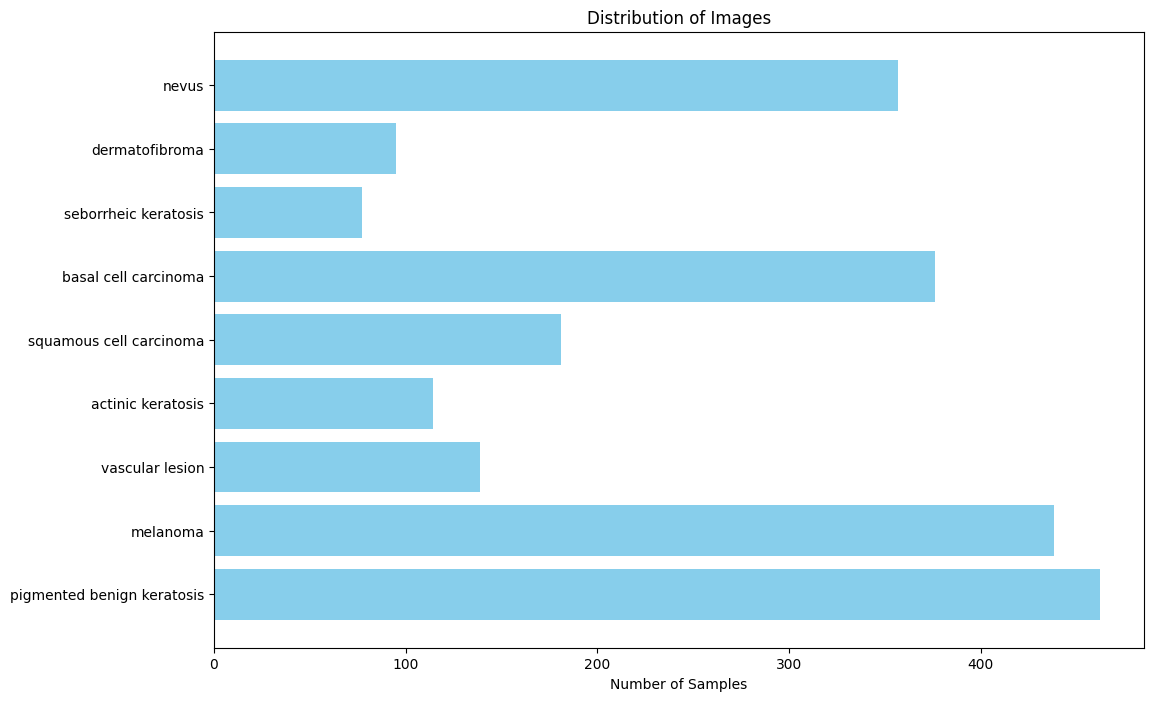

In [99]:
# Plotting the class distribution
labels = list(class_dict.keys())
values = list(class_dict.values())

# Create the bar chart
plt.figure(figsize=(12, 8))
plt.barh(labels, values, color='skyblue')
plt.xlabel('Number of Samples')
plt.title('Distribution of Images')

# Display the plot
plt.show()

As seen above, the classes are definetly not split evenly. **Melanoma** and **Pigmented Benign Kertosis** have far higher samples than **Seborrheic Keratosis** and **Dermatofibroma**. Rather than adressing the class imbalance right away let us create a base model CNN network for our first model.

Before that let us see a few samples of each class

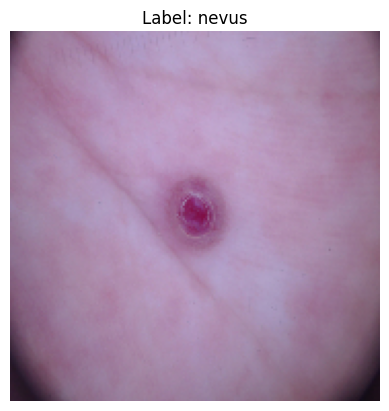

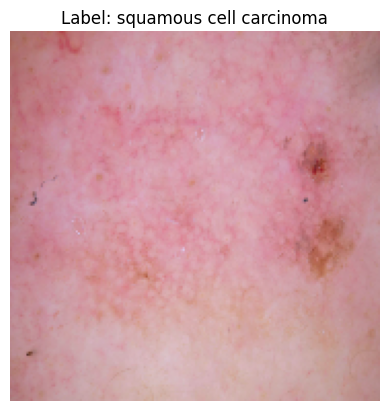

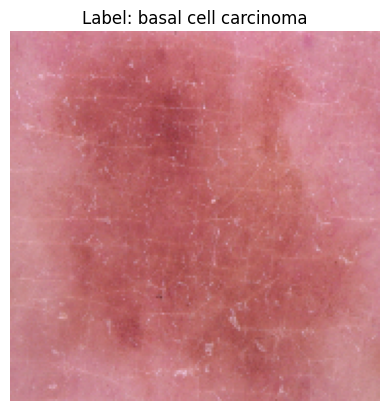

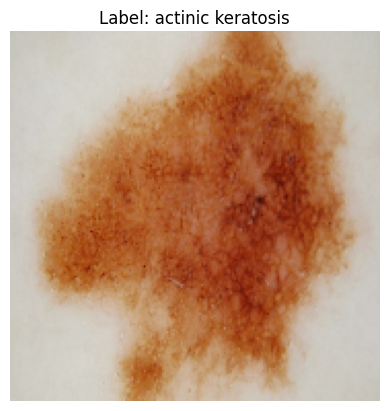

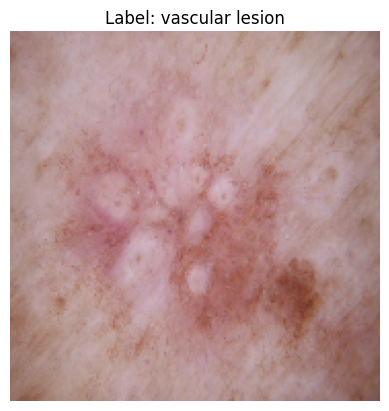

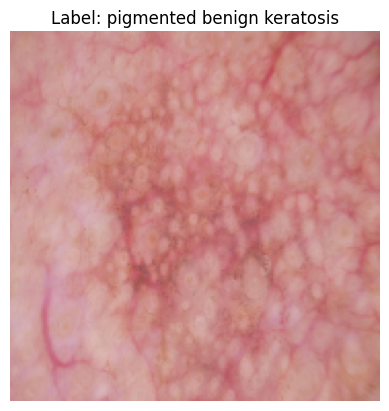

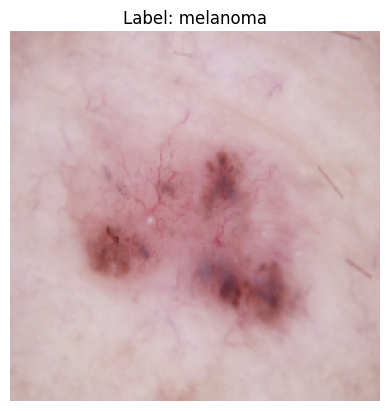

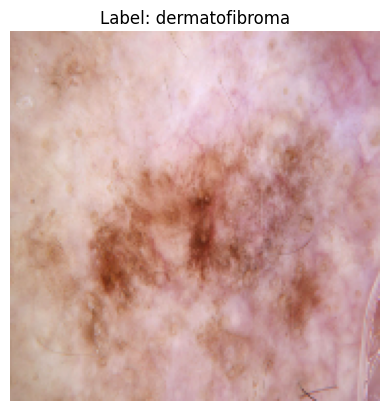

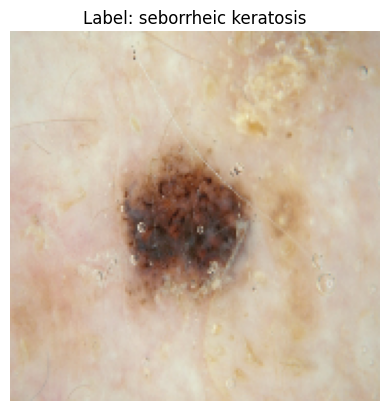

In [15]:
# Function to display an image
def display_image(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(f'Label: {class_names[label]}')
    plt.axis('off')
    plt.show()

displayed_classes = set()

# Iterate through the dataset to find one image per class
for images, labels in train_ds.unbatch():  # Unbatch to process one image at a time
    label = np.argmax(labels.numpy())  # Get the index of the max value in the one-hot encoded label
    if label not in displayed_classes:
        displayed_classes.add(label)
        image = images.numpy().astype("uint8")
        display_image(image, label)
    if len(displayed_classes) == len(class_names):
        break

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
# model architecture
model_1 = Sequential()

model_1.add(layers.Rescaling(1./255,input_shape=(img_height,img_width,3)))

model_1.add(Conv2D(32, (3, 3), input_shape = (img_height, img_width, 32)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(64, (3, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(128, (3, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Flatten())
model_1.add(Dense(128)) 
model_1.add(Activation('relu'))

model_1.add(Dropout(0.25))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))


# Compile the model
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 41, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 9)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model_1_epochs = 25

# Train the model
history = model_1.fit(
    train_ds,
#     steps_per_epoch=len(train_ds),
    validation_data=val_ds,
#     validation_steps=len(val_ds),
    epochs=model_1_epochs)

Epoch 1/25
 3/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.0955 - loss: 2.9938  

I0000 00:00:1721206484.603715     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721206484.624104     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2166 - loss: 2.2949

W0000 00:00:1721206487.166182     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.2177 - loss: 2.2870 - val_accuracy: 0.3333 - val_loss: 1.8501
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2868 - loss: 1.8891 - val_accuracy: 0.3781 - val_loss: 1.6927
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3558 - loss: 1.7436 - val_accuracy: 0.4116 - val_loss: 1.6673
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3873 - loss: 1.6915 - val_accuracy: 0.5101 - val_loss: 1.4871
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4880 - loss: 1.4911 - val_accuracy: 0.5056 - val_loss: 1.4575
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5152 - loss: 1.3678 - val_accuracy: 0.4877 - val_loss: 1.4026
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5388 - loss: 1.3263 - val_accuracy: 0.5302 - val_loss: 1.3670
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5636 - loss: 1.2565 - val_accuracy: 0.5056 - val_loss: 

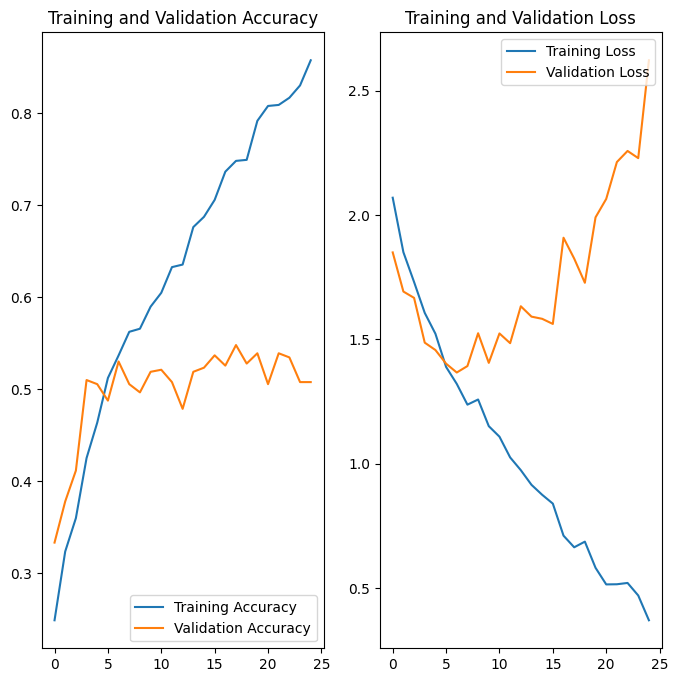

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(model_1_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

> As very clearly seen above, the model is overfitting. We can now try to augment the input images to try to increase the training size. Other steps that can be taken is to add dropouts and batch normilization layers in the model and then compare it with the benchmark.

In [29]:
# model architecture
model_2 = Sequential()

model_2.add(layers.Rescaling(1./255,input_shape=(img_height,img_width,3)))

model_2.add(Conv2D(32, (3, 3), input_shape = (img_height, img_width, 32)))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(128, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Flatten())
model_2.add(Dense(128))
model_2.add(Activation('relu'))

model_2.add(Dropout(0.25))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))


# Compile the model
model_2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 87, 87, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 87, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 41, 41, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 41, 41, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 41, 41, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 18, 18, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 289,065 (1.10 MB)

 Trainable params: 288,617 (1.10 MB)

 Non-trainable params: 448 (1.75 KB)

In [31]:
model_2_epochs = 25

# Train the model
history_2 = model_2.fit(
    train_ds,
#     steps_per_epoch=len(train_ds),
    validation_data=val_ds,
#     validation_steps=len(val_ds),
    epochs=model_2_epochs)

Epoch 1/25
 5/56 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1799 - loss: 4.0482 

W0000 00:00:1721207956.569387     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2698 - loss: 2.6134

W0000 00:00:1721207958.841039     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.2708 - loss: 2.6040 - val_accuracy: 0.0403 - val_loss: 3.9022
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4518 - loss: 1.5097 - val_accuracy: 0.1499 - val_loss: 5.4387
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4644 - loss: 1.4968 - val_accuracy: 0.1499 - val_loss: 5.0037
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5145 - loss: 1.3827 - val_accuracy: 0.1499 - val_loss: 3.4192
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5322 - loss: 1.3186 - val_accuracy: 0.1499 - val_loss: 3.4934
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5462 - loss: 1.2790 - val_accuracy: 0.1521 - val_loss: 3.3836
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5541 - loss: 1.2194 - val_accuracy: 0.1969 - val_loss: 3.3264
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5440 - loss: 1.2539 - val_accuracy: 0.2327 - val_loss: 2

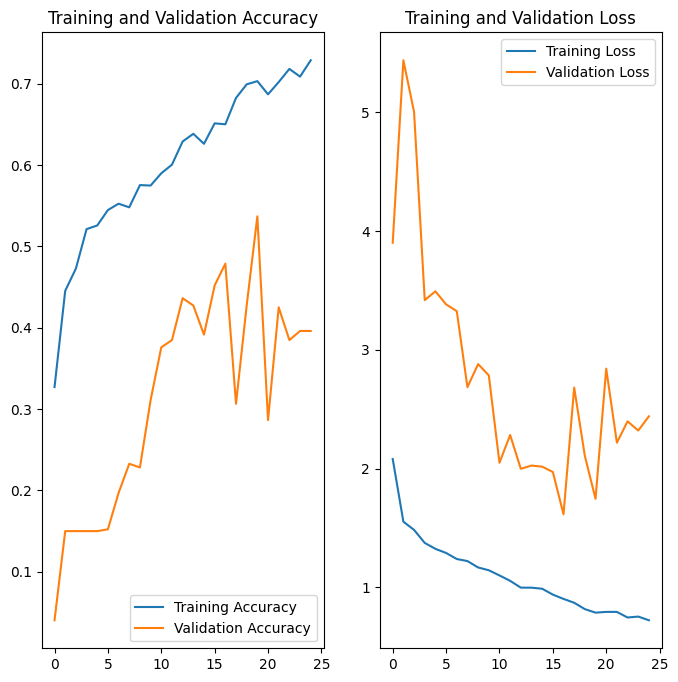

In [32]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(model_2_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

> It is quite evident that even after adding more convolutional layers, the model is  only underfitting therby proving the lessons taught in this module. Now we can start augmenting the input images to increase the size of the training data.

In [33]:
import os
import shutil

def move_files_and_remove_folder(source_folder):
    # Get the parent folder of the source folder
    parent_folder = os.path.dirname(source_folder)

    # Check if the source folder exists
    if not os.path.exists(source_folder):
        print(f"The folder {source_folder} does not exist.")
        return

    # Move files from source folder to parent folder
    for filename in os.listdir(source_folder):
        source_file = os.path.join(source_folder, filename)
        destination_file = os.path.join(parent_folder, filename)

        if os.path.isfile(source_file):
            shutil.move(source_file, destination_file)
            print(f"Moved: {source_file} to {destination_file}")

    # Remove the source folder
    try:
        os.rmdir(source_folder)
        print(f"Removed the folder: {source_folder}")
    except OSError as e:
        print(f"Error: {source_folder} : {e.strerror}")

In [34]:
!pip install Augmentor

In [30]:
import Augmentor
# Passing the path of the image directory

target_num = 500

for each in class_dict.keys():
    if class_dict[each] < target_num:
        p = Augmentor.Pipeline(f'{data_dir_train}/{each}')

        # Defining augmentation parameters and generating 5 samples
        p.flip_left_right(0.5) # Flipping is a valid option here for our use case
        p.rotate(0.5, 25, 25) # Anlge of photo can vary as well
        p.zoom(probability = 0.3, min_factor = 1.1, max_factor = 1.3) # distance b/w camera and subject can also vary
        p.sample(target_num)

Insufficient rights to read or write output directory (/kaggle/input/cnn-melanoma-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output)
Initialised with 462 image(s) found.
Output directory set to /kaggle/input/cnn-melanoma-images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Executing Pipeline:   0%|          | 0/538 [00:00<?, ? Samples/s]


AttributeError: 'FileNotFoundError' object has no attribute 'message'

In [35]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/kaggle/input/augmented-melanoma-images/content/CNN_assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/kaggle/input/augmented-melanoma-images/content/CNN_assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [36]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

4500
118


In [38]:
# Reloading training dataset with augmented images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size = (img_height, img_width),
    labels='inferred',
    label_mode='categorical',
    validation_split = validation_split,
    subset = 'training',
    batch_size=batch_size,
    seed=123
    )

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [39]:
# Reloading validation dataset with augmented images
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size = (img_height, img_width),
    validation_split = validation_split,
    subset = "validation",
    seed=123,
    )

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [40]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [41]:
class_names = os.listdir(data_dir_train)
num_classes = len(class_names)
class_counts = np.zeros(num_classes, dtype=int)

class_dict = {}
# Iterate through the dataset and count samples per class
for each_class in os.listdir(data_dir_train):
    class_dict[each_class] = len(os.listdir(f"{data_dir_train}/{each_class}"))
    
class_dict

{'pigmented benign keratosis': 500,
 'melanoma': 500,
 'vascular lesion': 500,
 'actinic keratosis': 500,
 'squamous cell carcinoma': 500,
 'basal cell carcinoma': 500,
 'seborrheic keratosis': 500,
 'dermatofibroma': 500,
 'nevus': 500}

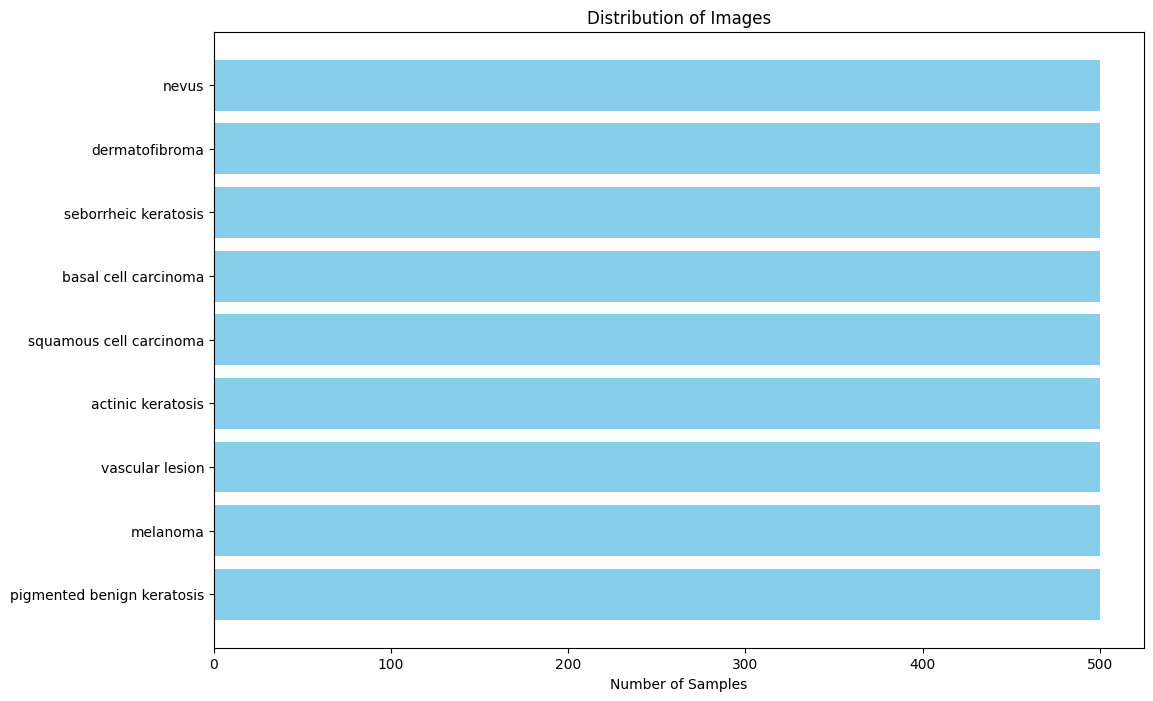

In [42]:
# Extract keys and values
labels = list(class_dict.keys())
values = list(class_dict.values())

# Create the bar chart
plt.figure(figsize=(12, 8))
plt.barh(labels, values, color='skyblue')
plt.xlabel('Number of Samples')
plt.title('Distribution of Images')

# Display the plot
plt.show()

Now we have succesfully augmented the input images and have overcome class imbalance. A sample of the augmented images for each class can be seen below.

pigmented benign keratosis_original_ISIC_0028347.jpg_cbe4ac7d-0455-4a6e-a2ca-05b4adef1147.jpg


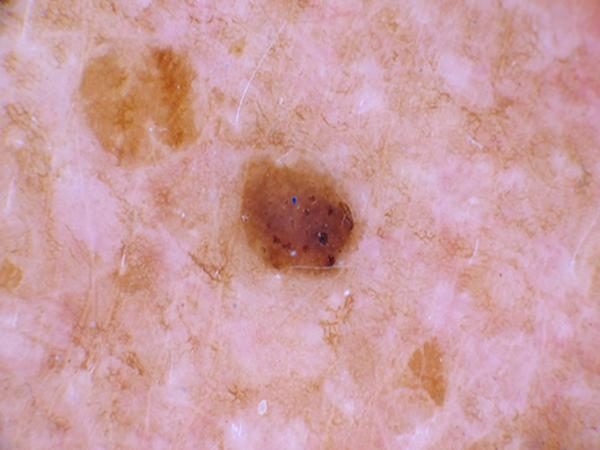

pigmented benign keratosis_original_ISIC_0026787.jpg_dcf30ada-a752-47bb-872f-fd1579e02c5a.jpg


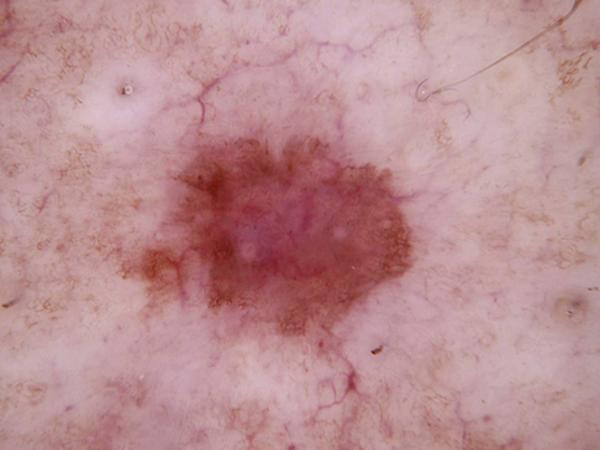

pigmented benign keratosis_original_ISIC_0027094.jpg_eebd4223-6f5b-4580-b34d-5ce890d6296f.jpg


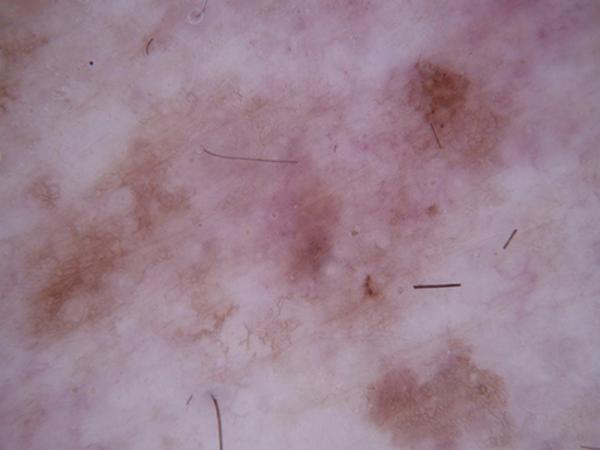

pigmented benign keratosis_original_ISIC_0025484.jpg_89468e6d-5e3f-4d95-8df5-cec3b8b10a76.jpg


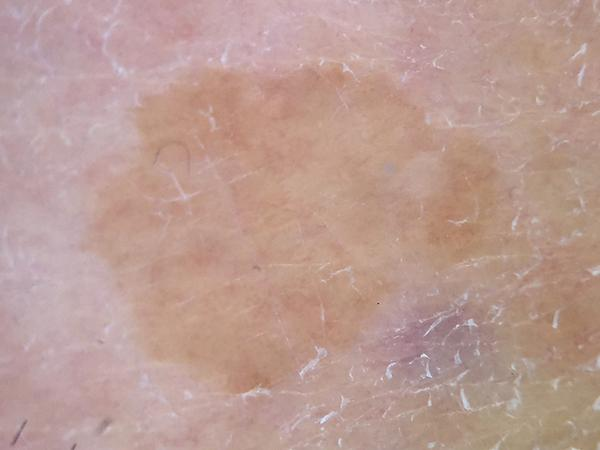

pigmented benign keratosis_original_ISIC_0026614.jpg_af07e021-6a3f-4ea6-be1c-8a287aad8cf2.jpg


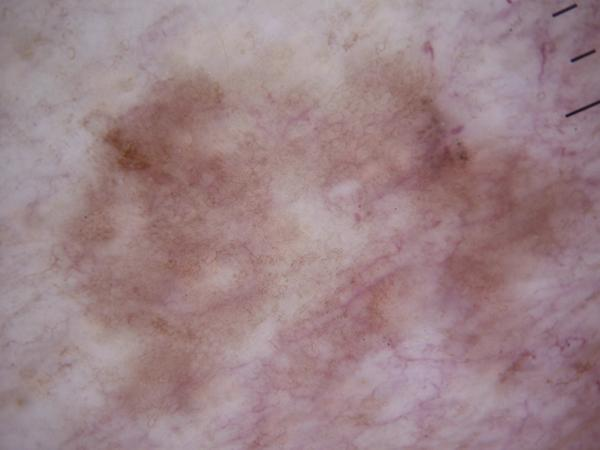

pigmented benign keratosis_original_ISIC_0025529.jpg_b5f4ec6f-6718-40ef-be02-4189f792cde9.jpg
melanoma_original_ISIC_0000555.jpg_7dc81501-acd3-4b43-9b41-1735f687ccaa.jpg


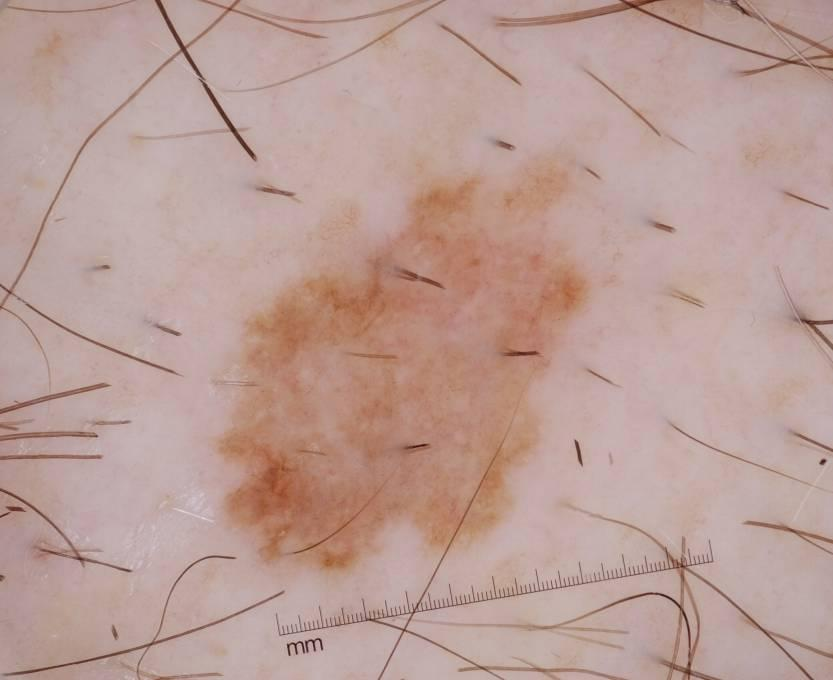

melanoma_original_ISIC_0001112.jpg_213d7ee0-5032-4c6e-9fa6-a83326e217bf.jpg


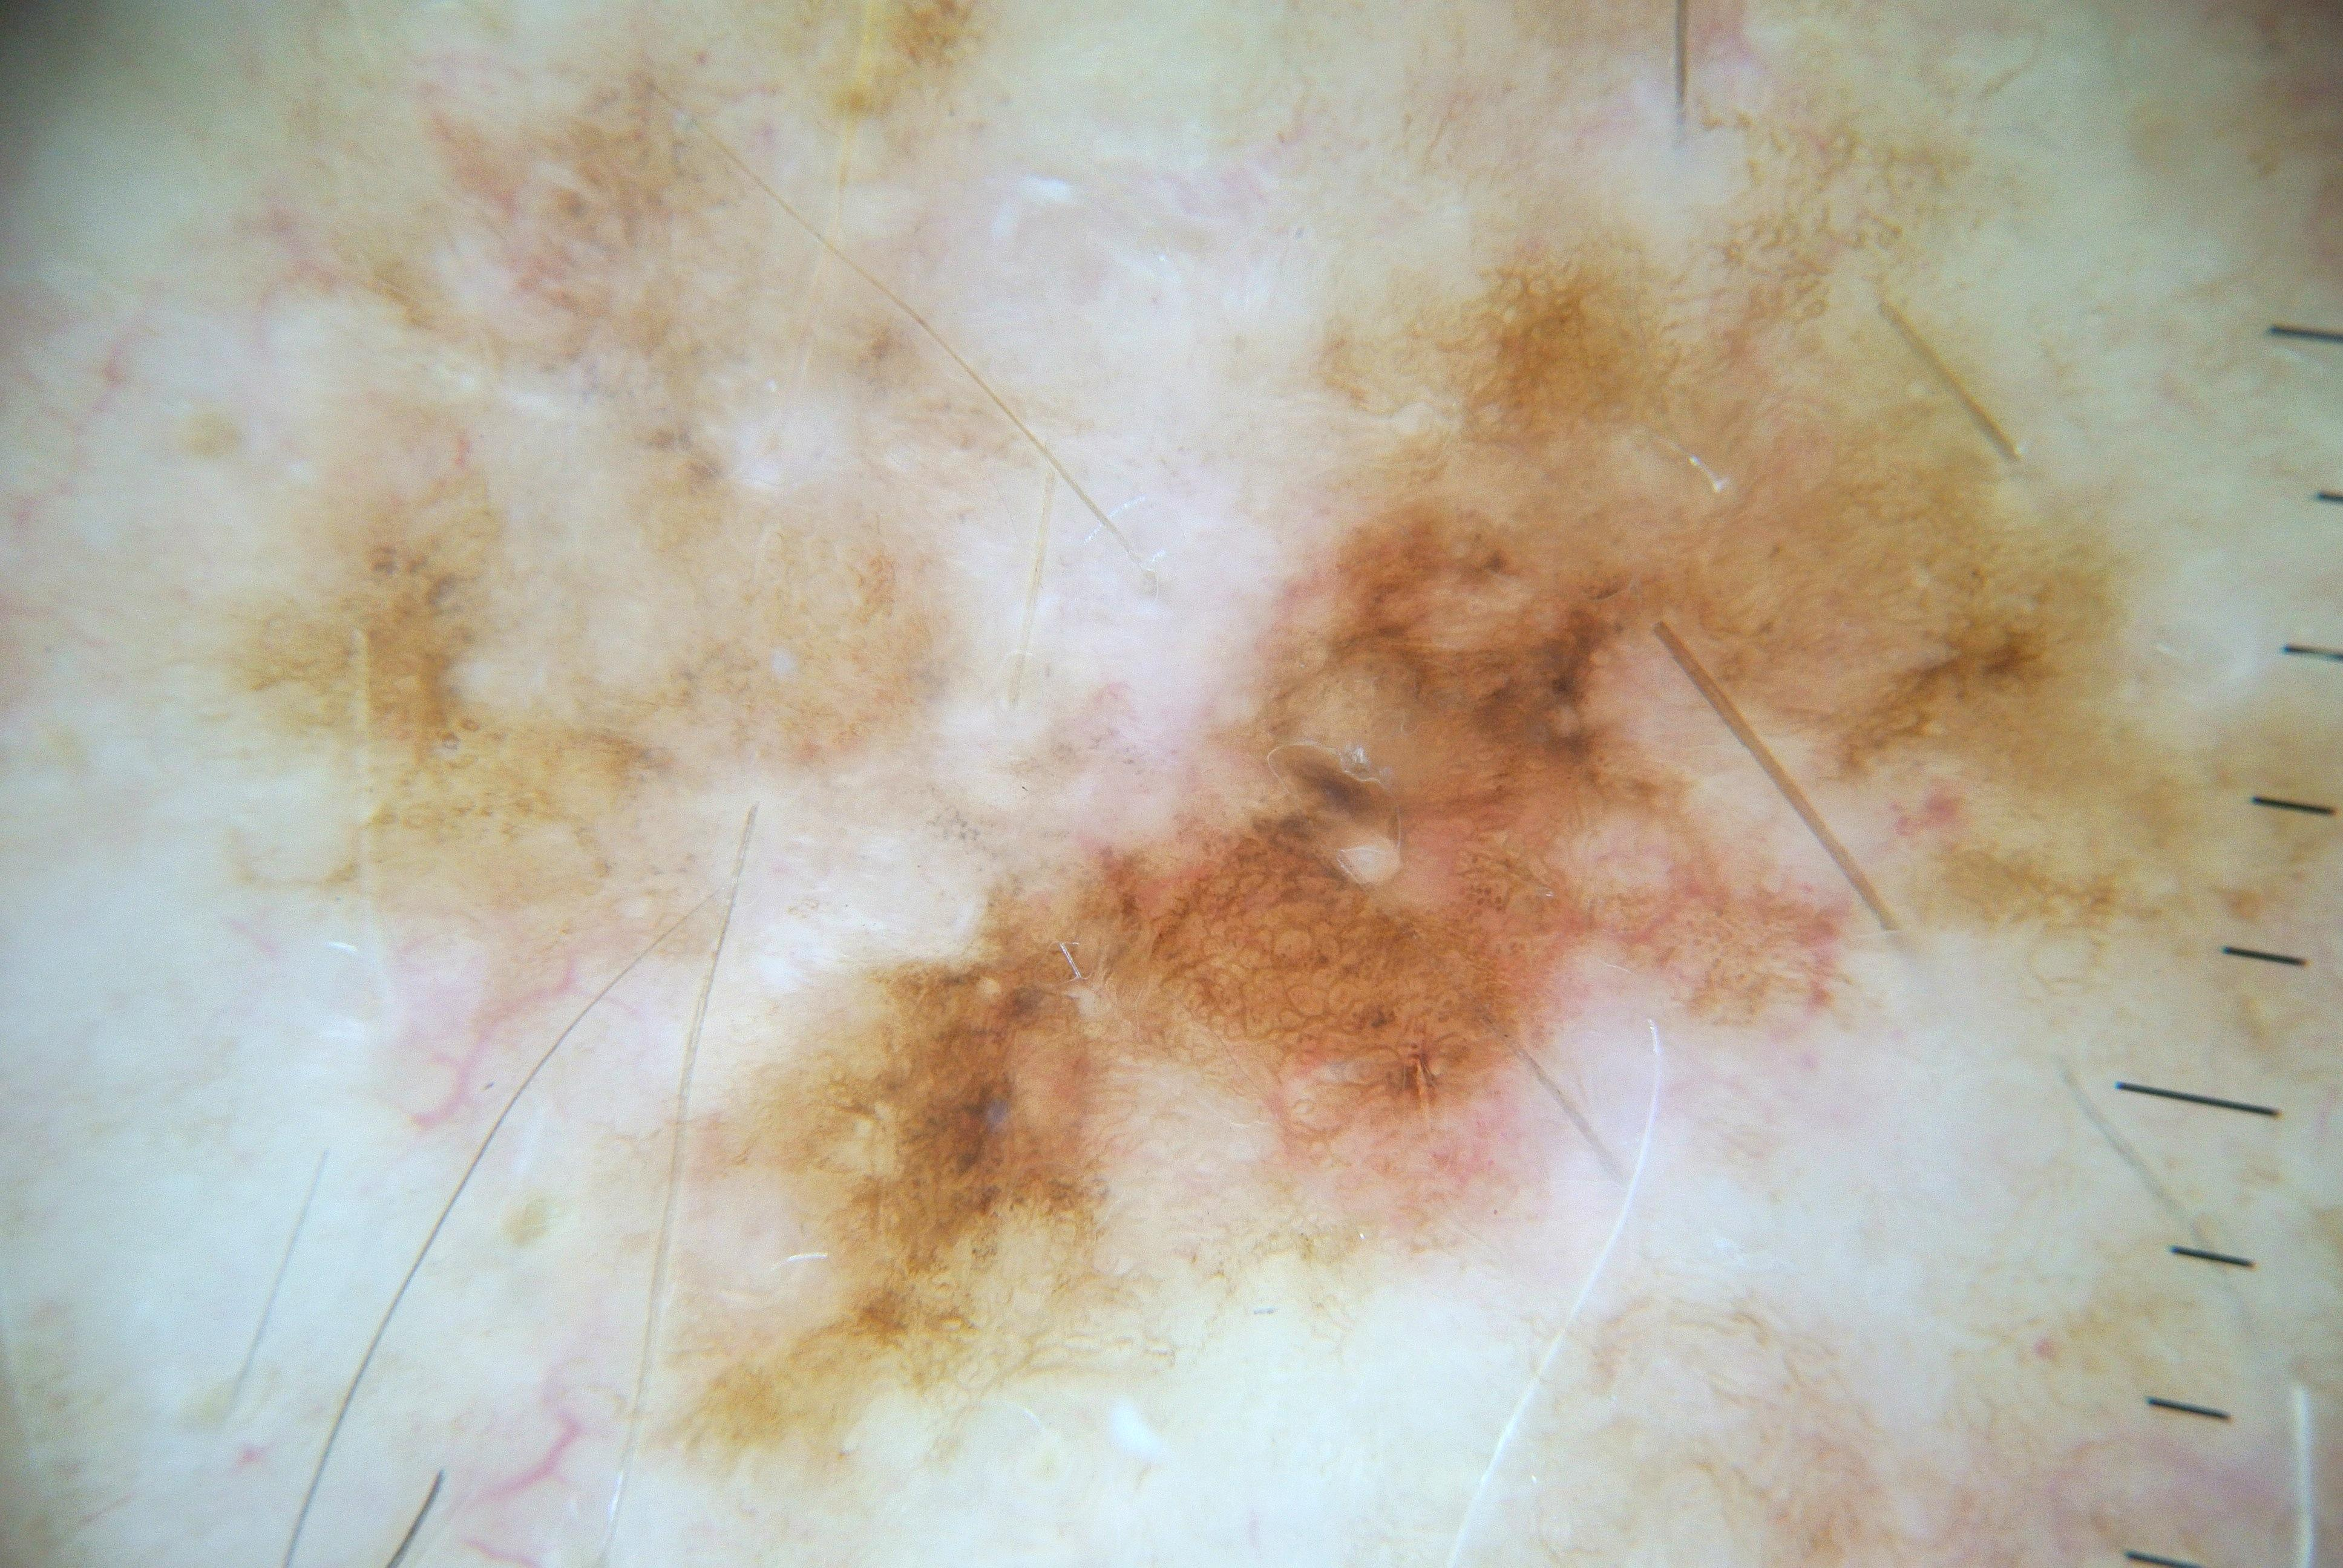

melanoma_original_ISIC_0010564.jpg_b3eb2103-b884-461c-b97a-ca866ecb3378.jpg


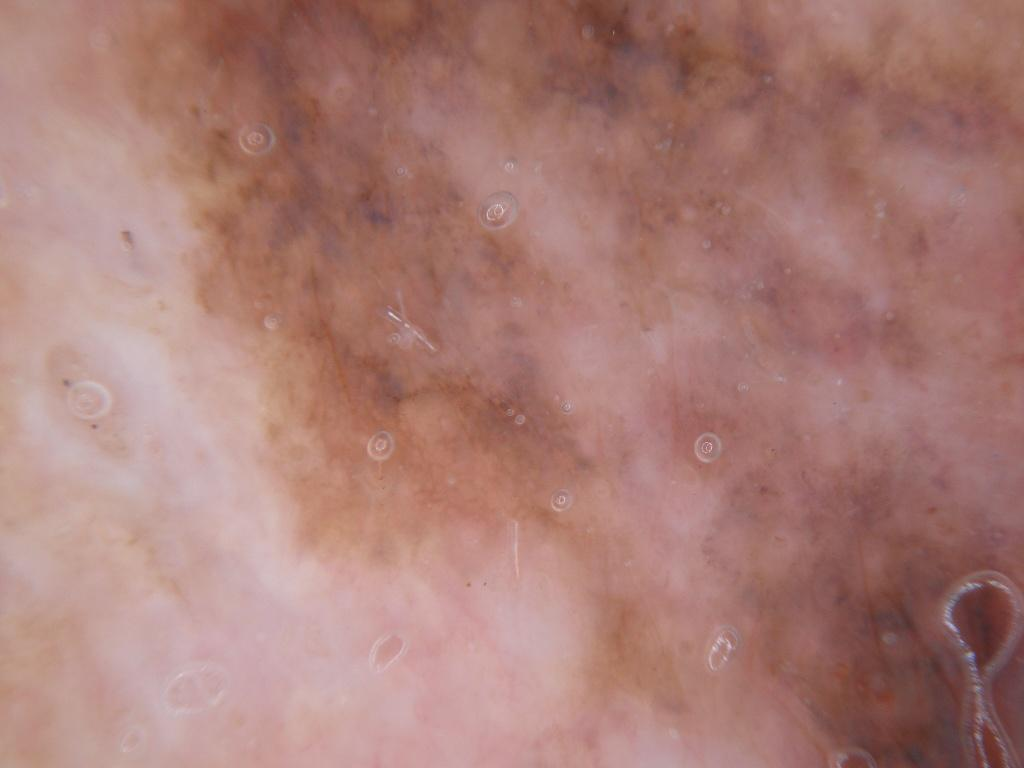

melanoma_original_ISIC_0010750.jpg_4e9a9bd8-6319-4f83-b9df-5dae1c01ee39.jpg


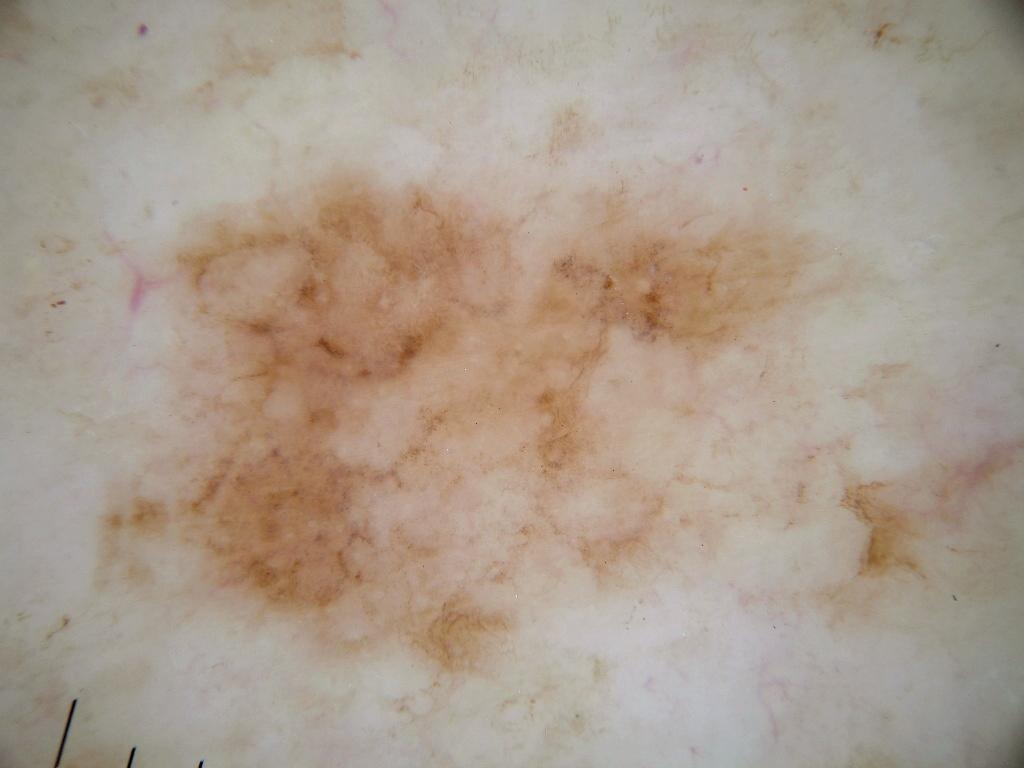

melanoma_original_ISIC_0000158.jpg_de13719c-91af-4d4f-bca4-8c801f644198.jpg


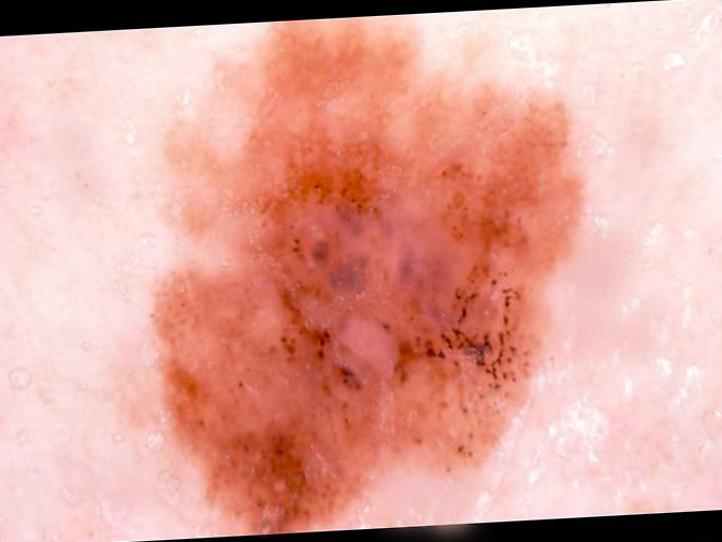

melanoma_original_ISIC_0011136.jpg_fb03e9e1-335d-4ee3-95ed-6930dce84dc0.jpg
vascular lesion_original_ISIC_0030606.jpg_69622d85-01f8-43af-b0d8-1e0360e89891.jpg


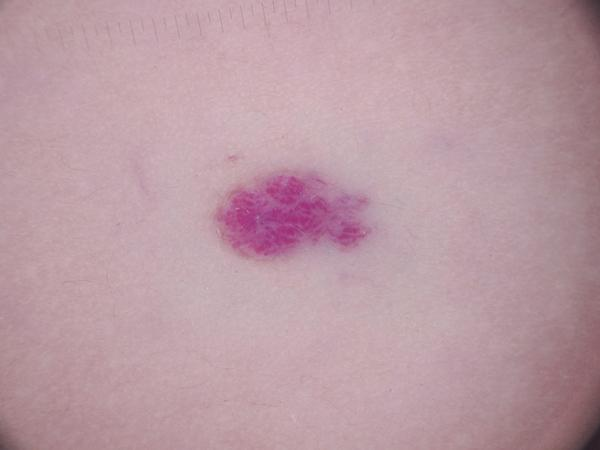

vascular lesion_original_ISIC_0032240.jpg_192049bd-bbf7-4a4b-9b04-cf3d054e4d25.jpg


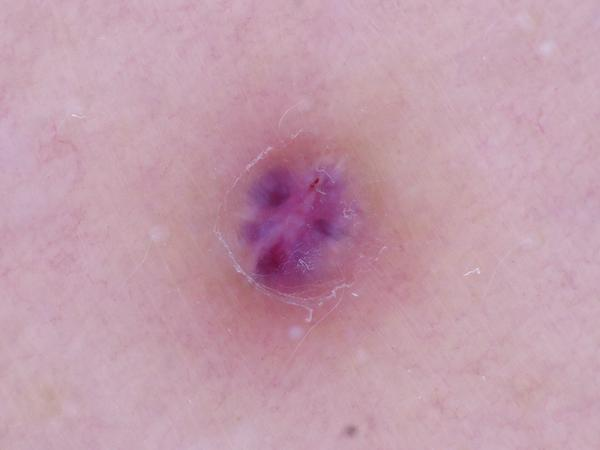

vascular lesion_original_ISIC_0027790.jpg_6d4b03da-020e-4279-95d5-fbfec356d712.jpg


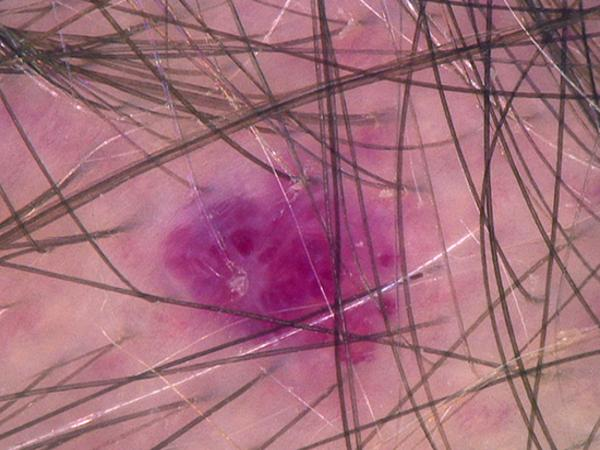

vascular lesion_original_ISIC_0033123.jpg_73ba90bb-12ea-4719-b13e-6ce6136dc57d.jpg


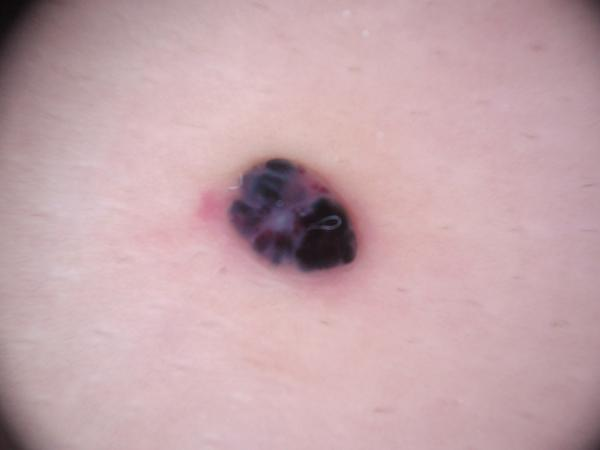

vascular lesion_original_ISIC_0025606.jpg_ad6344d2-1f5a-46b6-b1a8-6f6cdf21326d.jpg


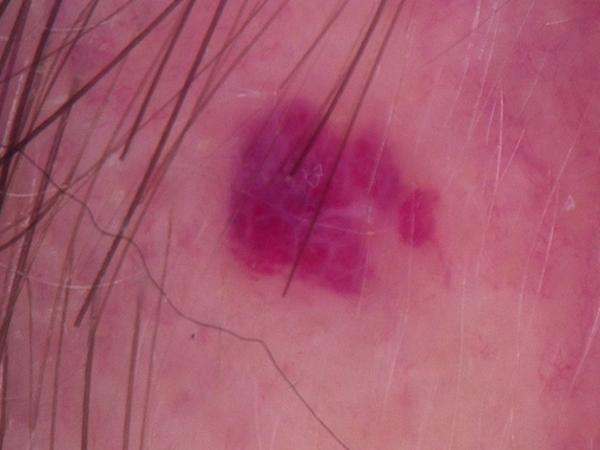

vascular lesion_original_ISIC_0027937.jpg_ae5cc5b6-059a-4e50-be38-6416e762795e.jpg
actinic keratosis_original_ISIC_0026171.jpg_527b8799-dcc1-4378-bb7e-108d2e3b288c.jpg


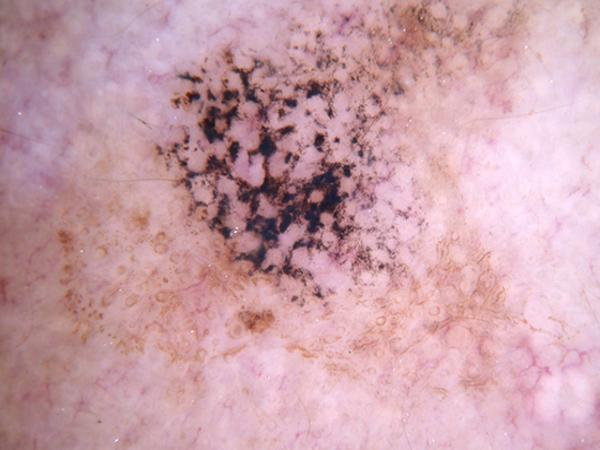

actinic keratosis_original_ISIC_0029141.jpg_523117b5-b42b-4cf4-b099-3c8e1b0225ca.jpg


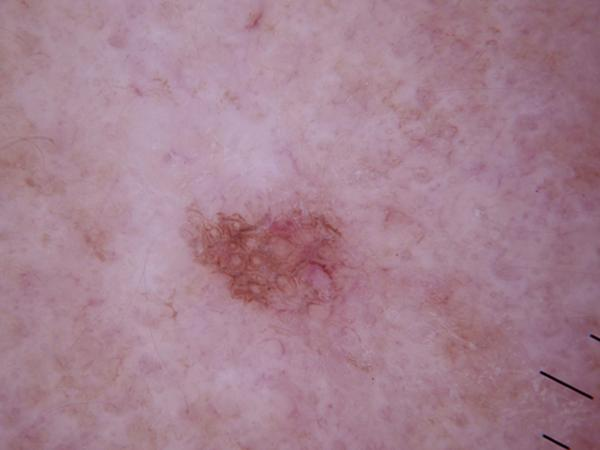

actinic keratosis_original_ISIC_0031292.jpg_181f7c27-560d-4be2-95da-1faac056255b.jpg


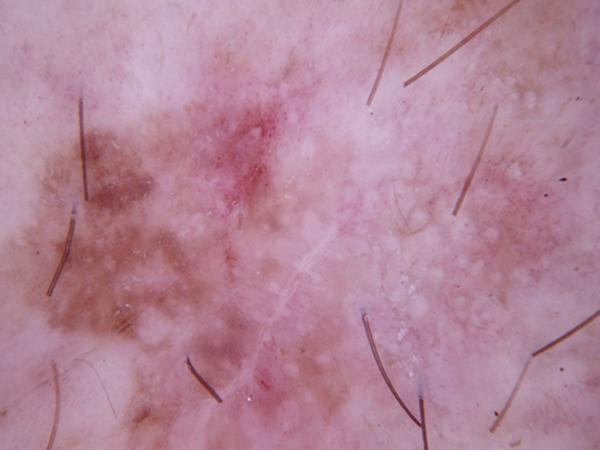

actinic keratosis_original_ISIC_0031823.jpg_4c0cceb3-0108-43db-a192-2c2667acccdb.jpg


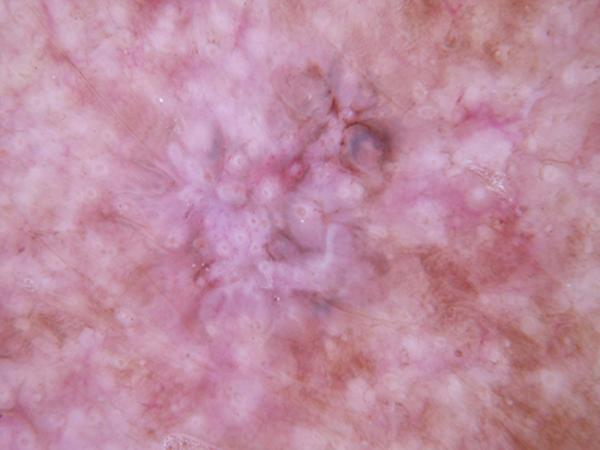

actinic keratosis_original_ISIC_0028990.jpg_707df714-8179-406a-9b7e-48cd94244142.jpg


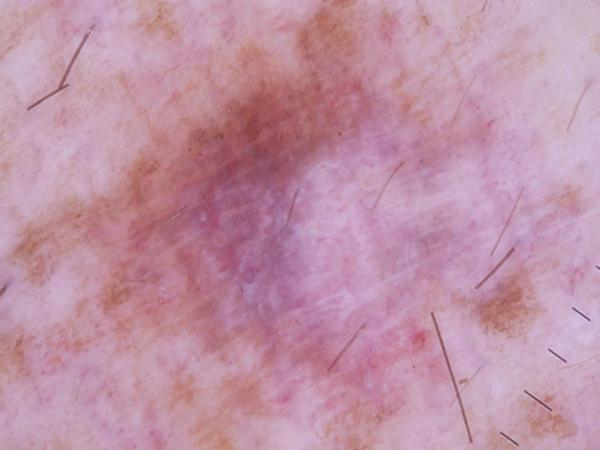

actinic keratosis_original_ISIC_0028990.jpg_ccc076ff-bde9-4f72-a549-81ec3e44f171.jpg
squamous cell carcinoma_original_ISIC_0027084.jpg_bbeff92e-fcea-45bd-a5b2-ec9a2c1b0982.jpg


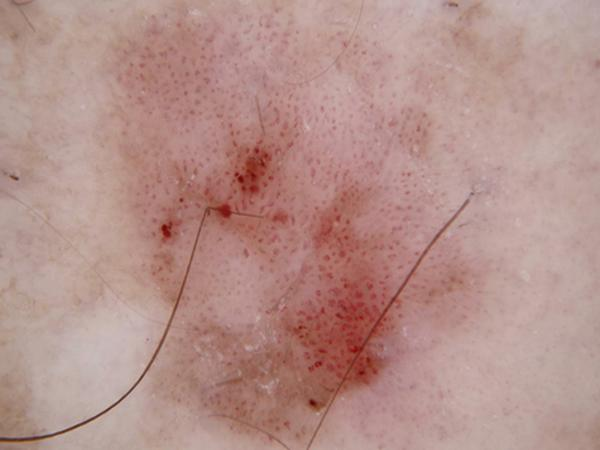

squamous cell carcinoma_original_ISIC_0027719.jpg_42e8ae67-f3f5-4a01-8975-ae9dfd30ed4a.jpg


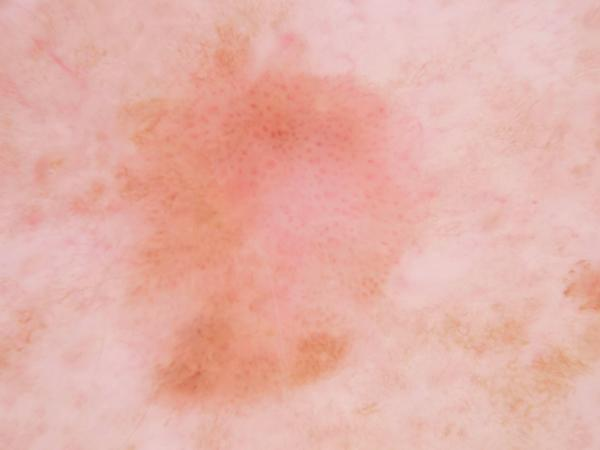

squamous cell carcinoma_original_ISIC_0027294.jpg_a9cef555-32a6-4fcf-bd8e-e7a9556e5954.jpg


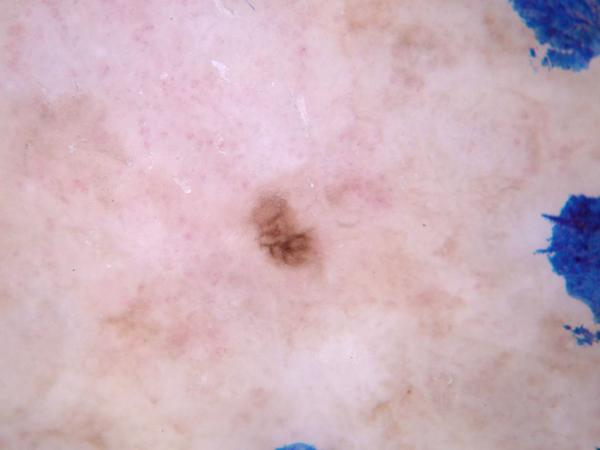

squamous cell carcinoma_original_ISIC_0027795.jpg_4b4ee0bd-2e46-465b-83de-ae68390dd597.jpg


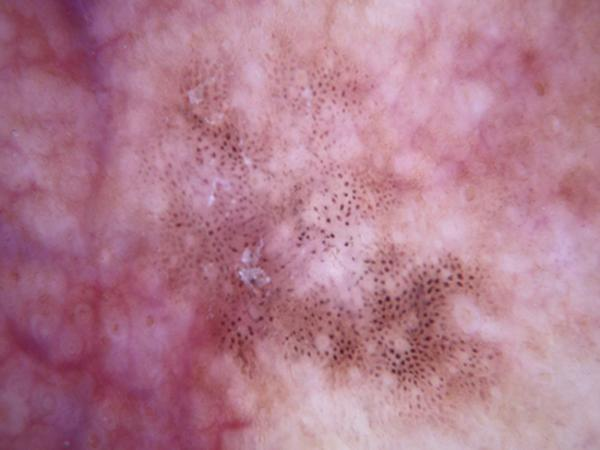

squamous cell carcinoma_original_ISIC_0025196.jpg_52d5aeec-e9fc-43d7-98ed-d9b7113cea3b.jpg


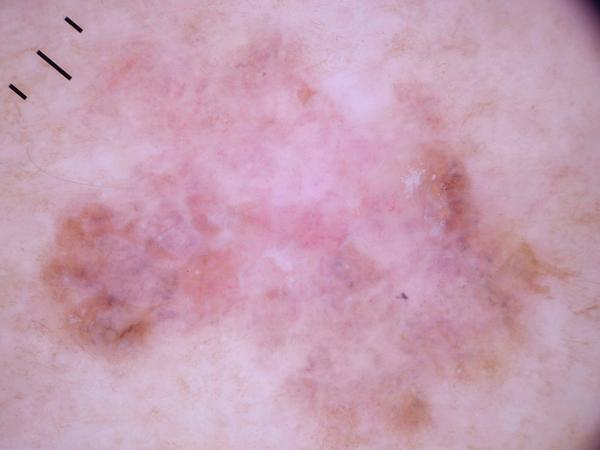

squamous cell carcinoma_original_ISIC_0025029.jpg_d26d7399-ea64-407e-92a8-4a5ffc544a24.jpg
basal cell carcinoma_original_ISIC_0027544.jpg_be1ced2c-ccb8-44f3-b4e2-8defb8462046.jpg


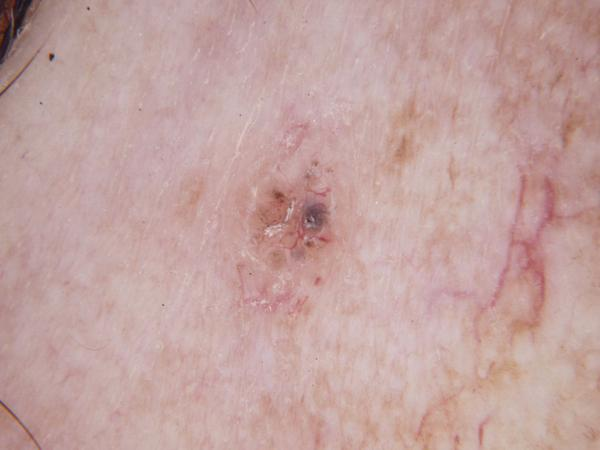

basal cell carcinoma_original_ISIC_0026766.jpg_eb229e5c-b95f-43dc-abf2-c259f8b5cd1b.jpg


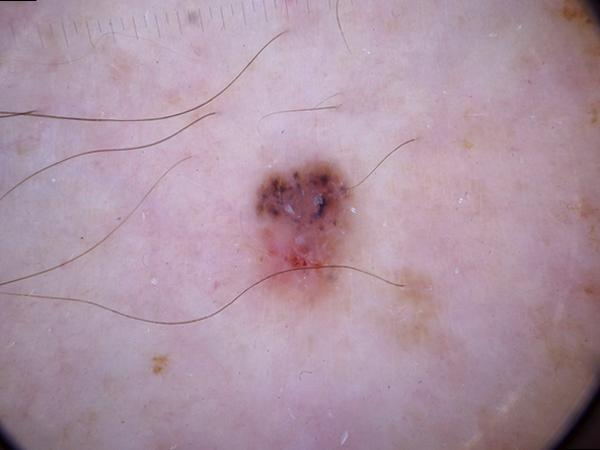

basal cell carcinoma_original_ISIC_0030766.jpg_71e97552-e944-4425-90bb-bcdc3bbcf776.jpg


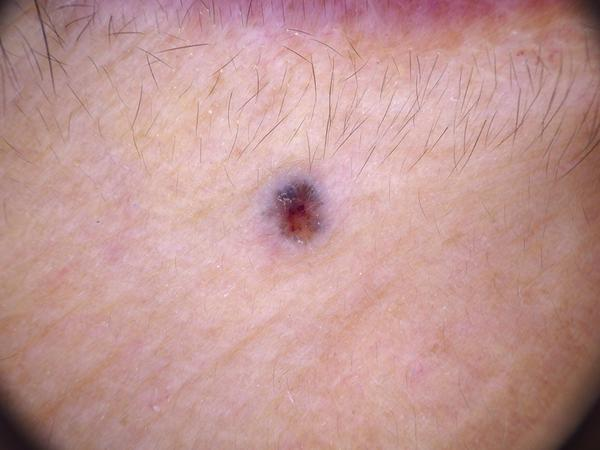

basal cell carcinoma_original_ISIC_0026831.jpg_18724d15-04e6-484d-9848-038bf2fe823a.jpg


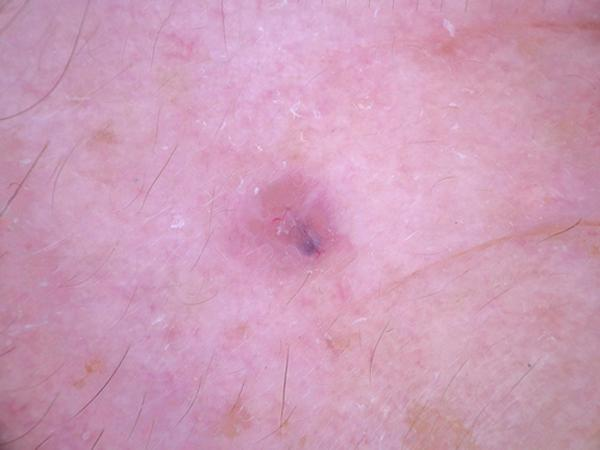

basal cell carcinoma_original_ISIC_0029020.jpg_e4dbfe29-05a5-46de-a2d8-2b6126ae4337.jpg


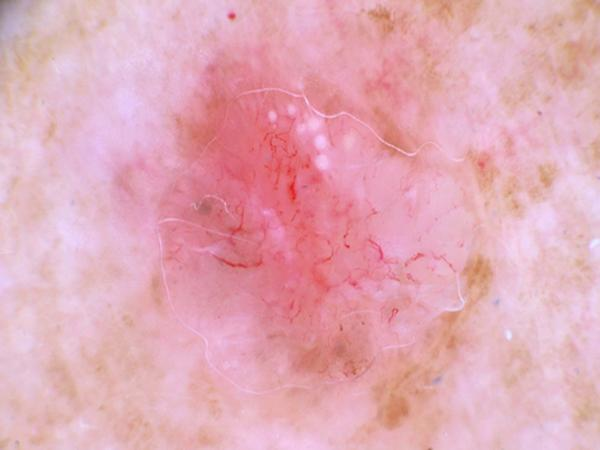

basal cell carcinoma_original_ISIC_0030233.jpg_1a3c97be-83e0-4796-8620-bb7c9b24df98.jpg
seborrheic keratosis_original_ISIC_0010982.jpg_5f6cb12f-f9da-44ea-8ead-0a7d2721957a.jpg


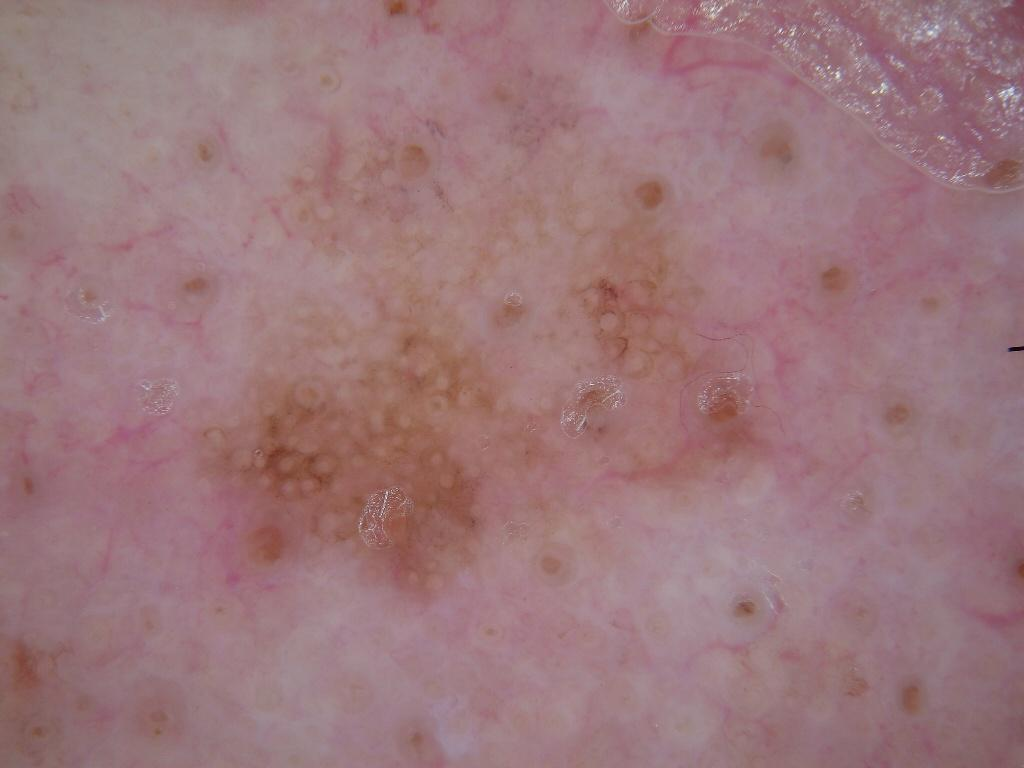

seborrheic keratosis_original_ISIC_0011099.jpg_3adde490-c5a9-4380-81cb-eb09da5bbea5.jpg


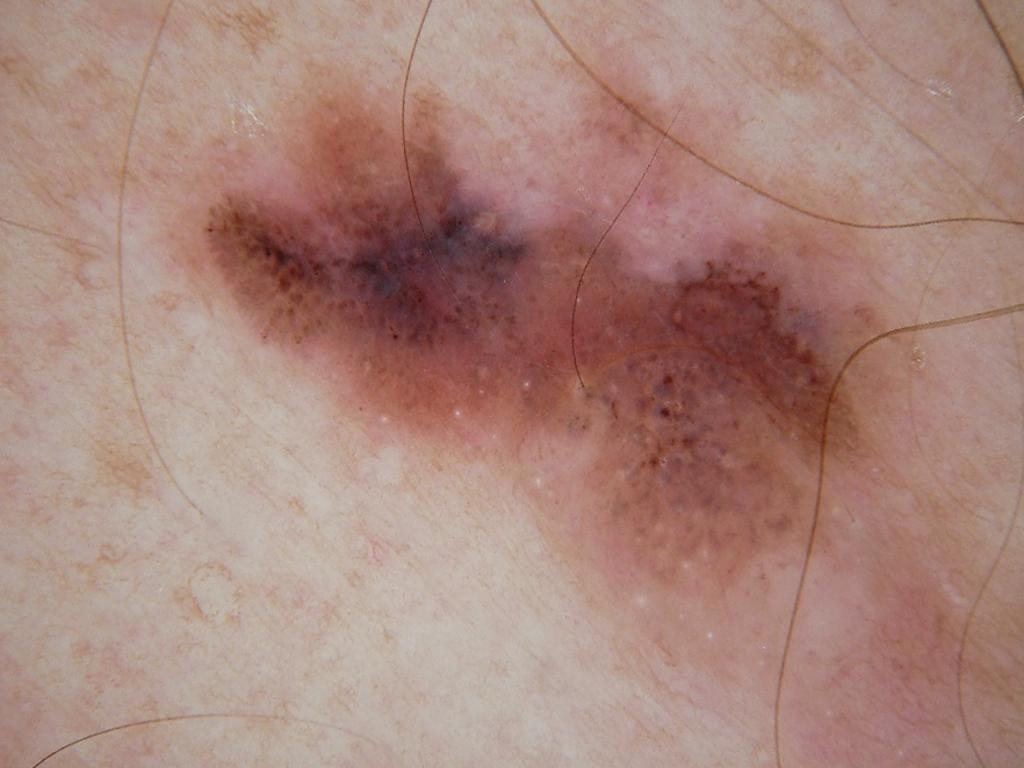

seborrheic keratosis_original_ISIC_0010917.jpg_42082ac4-9fab-4cc4-88bc-082dffcffd90.jpg


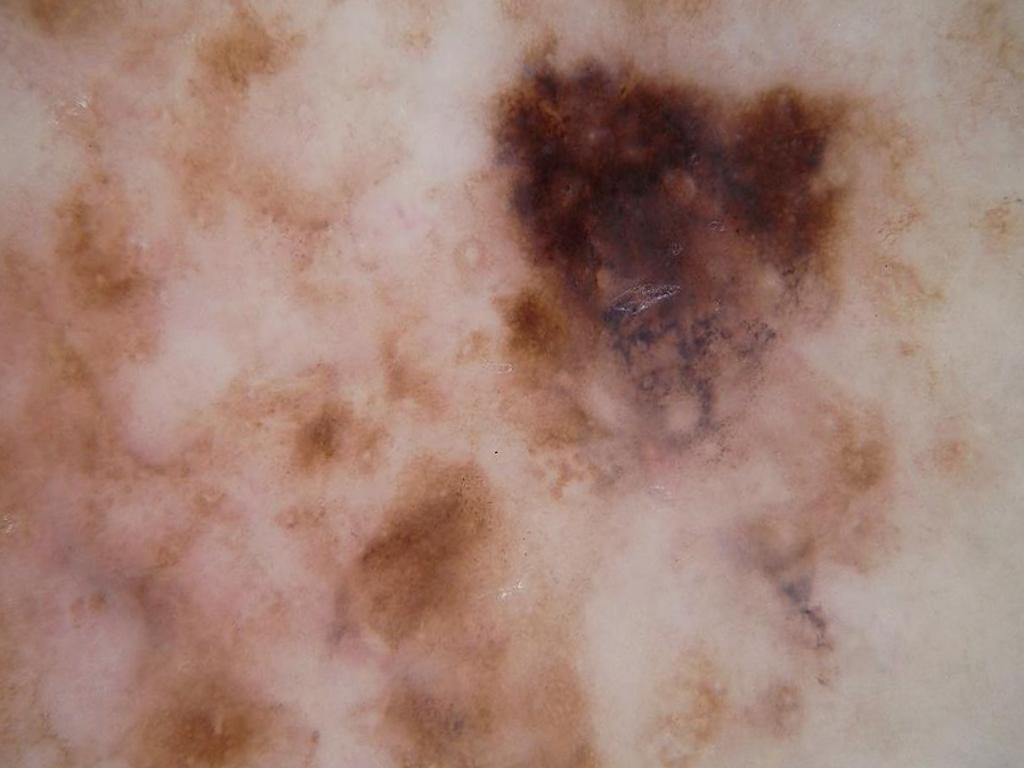

seborrheic keratosis_original_ISIC_0011158.jpg_8e8a3f65-084d-48ba-a3e4-29bba606dabb.jpg


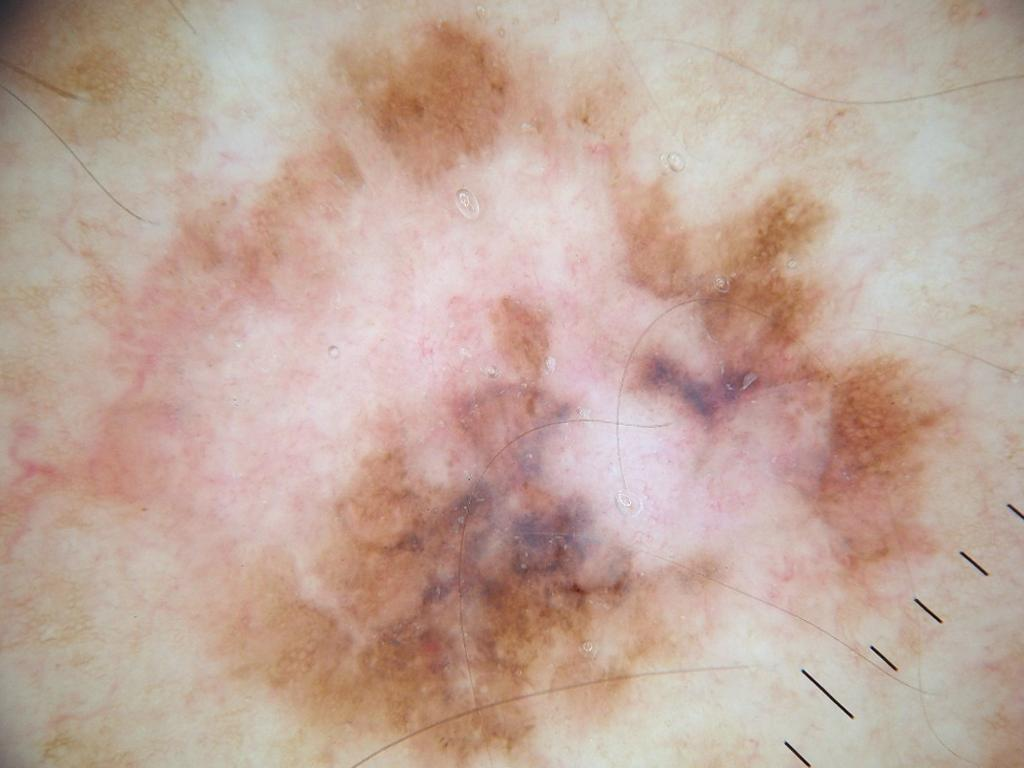

seborrheic keratosis_original_ISIC_0010977.jpg_f078456f-4fd2-49e4-adfa-2968f11d294a.jpg


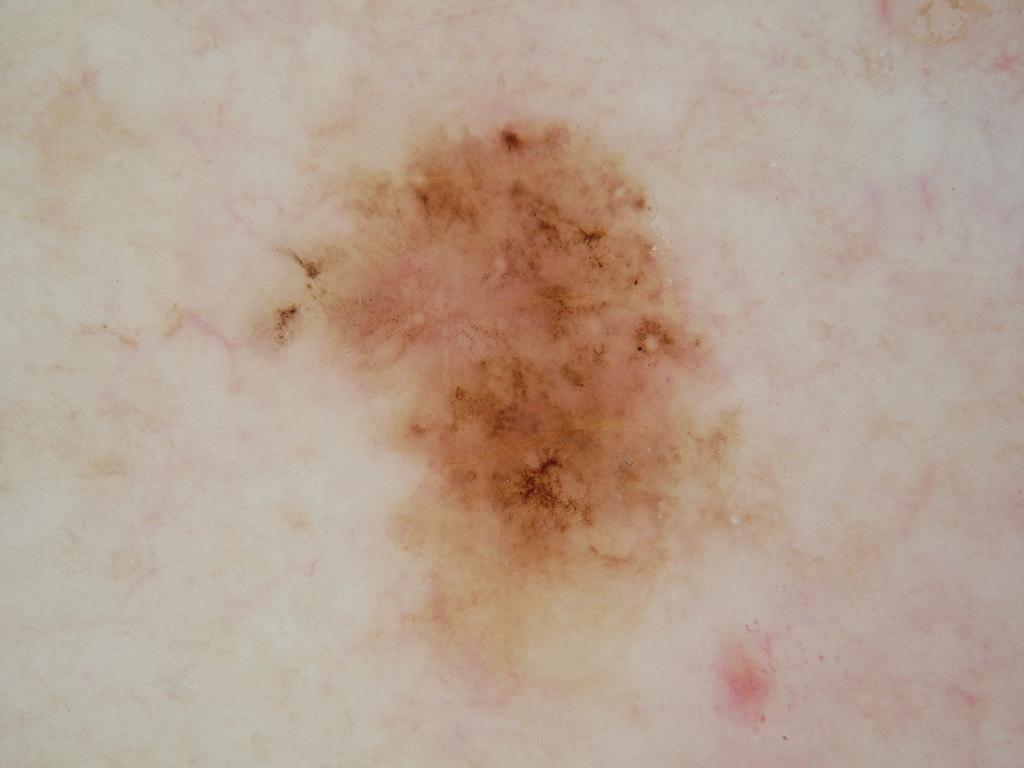

seborrheic keratosis_original_ISIC_0010925.jpg_fb0dee4f-1440-4c7b-a910-300fbd1c792c.jpg
dermatofibroma_original_ISIC_0033860.jpg_46cc42a4-3c5c-41b8-9189-7799e07910a4.jpg


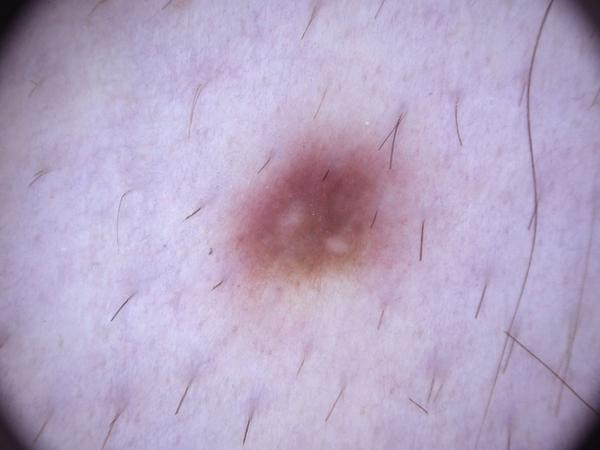

dermatofibroma_original_ISIC_0027745.jpg_5e5cab33-a5f9-431d-9129-e97ade696f1a.jpg


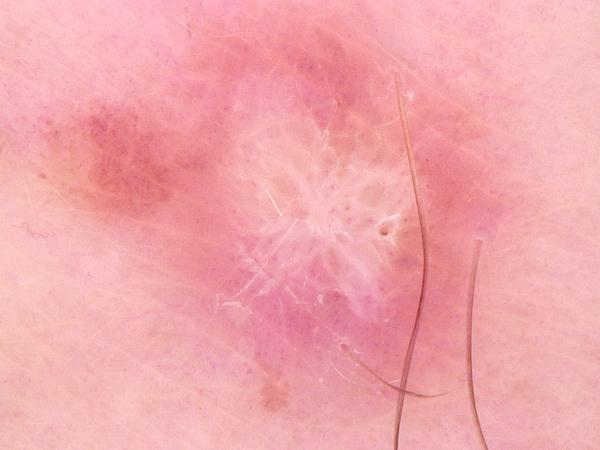

dermatofibroma_original_ISIC_0030830.jpg_e7a85976-2354-48ee-aab4-ecd7a16166a6.jpg


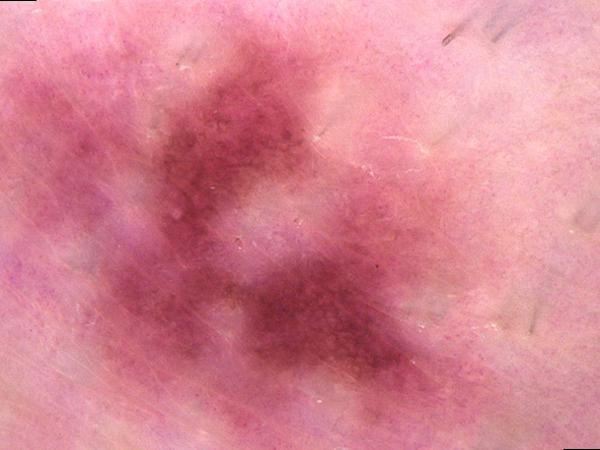

dermatofibroma_original_ISIC_0033695.jpg_cb137be8-b1cd-4134-9111-0d0b5ead55ce.jpg


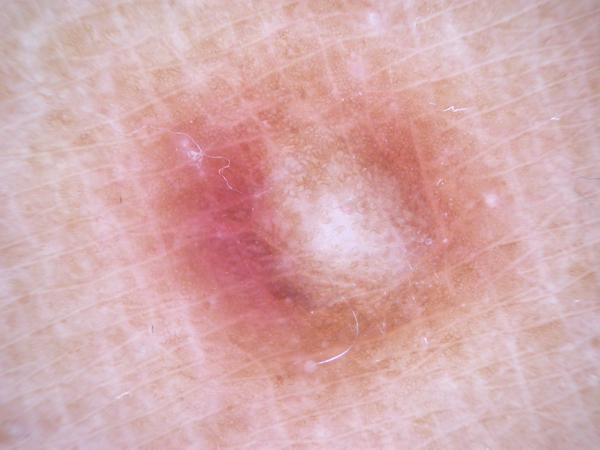

dermatofibroma_original_ISIC_0026471.jpg_6c3c4491-715a-4725-9965-a4334dd5a94e.jpg


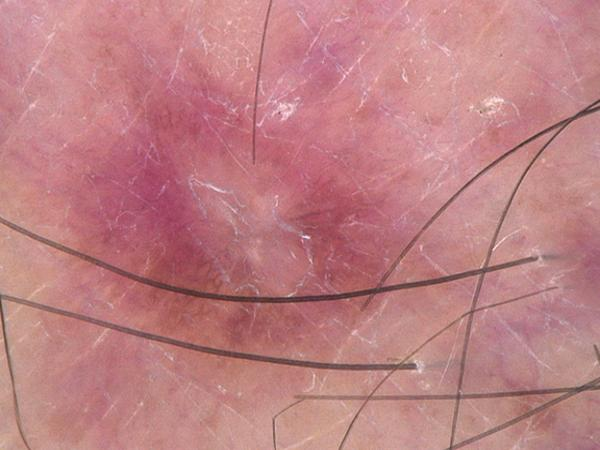

dermatofibroma_original_ISIC_0029824.jpg_16d8b7fa-fda5-4c1b-9574-ec7437c723ee.jpg
nevus_original_ISIC_0000350.jpg_713732c2-15c6-47f6-a07e-13f3fa17a244.jpg


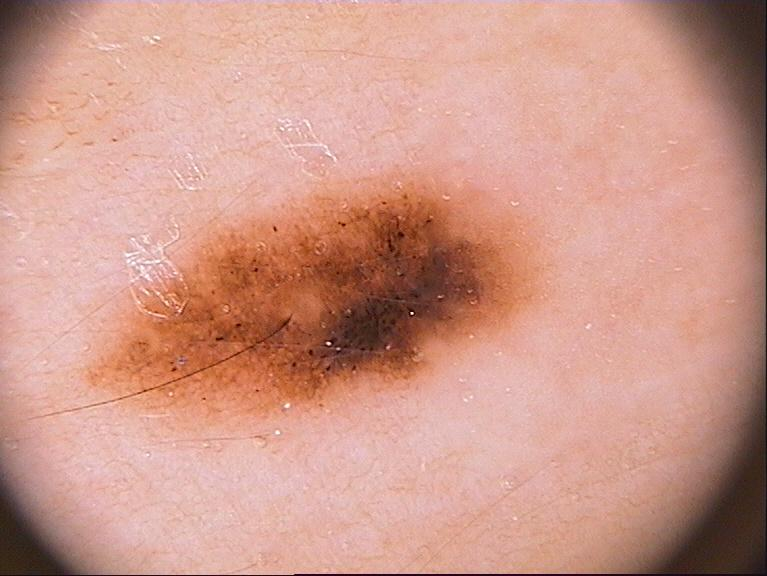

nevus_original_ISIC_0000497.jpg_6b6c8008-aa86-45c6-b12f-10967d43d595.jpg


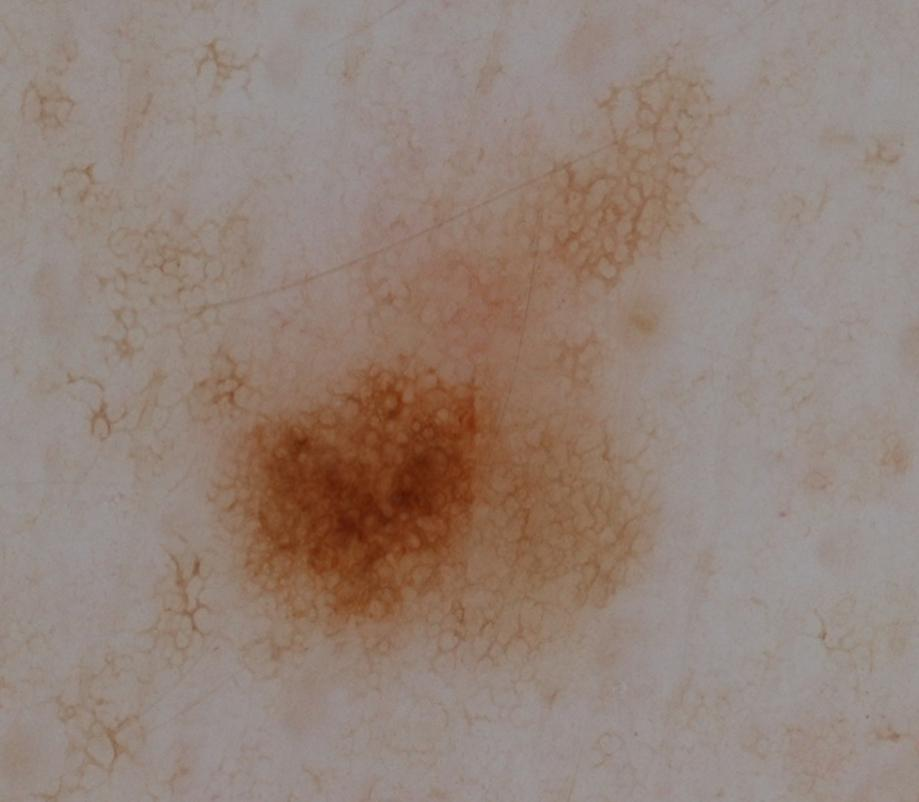

nevus_original_ISIC_0000496.jpg_31da8bc9-aa22-4eb3-9212-61fa8832e3d5.jpg


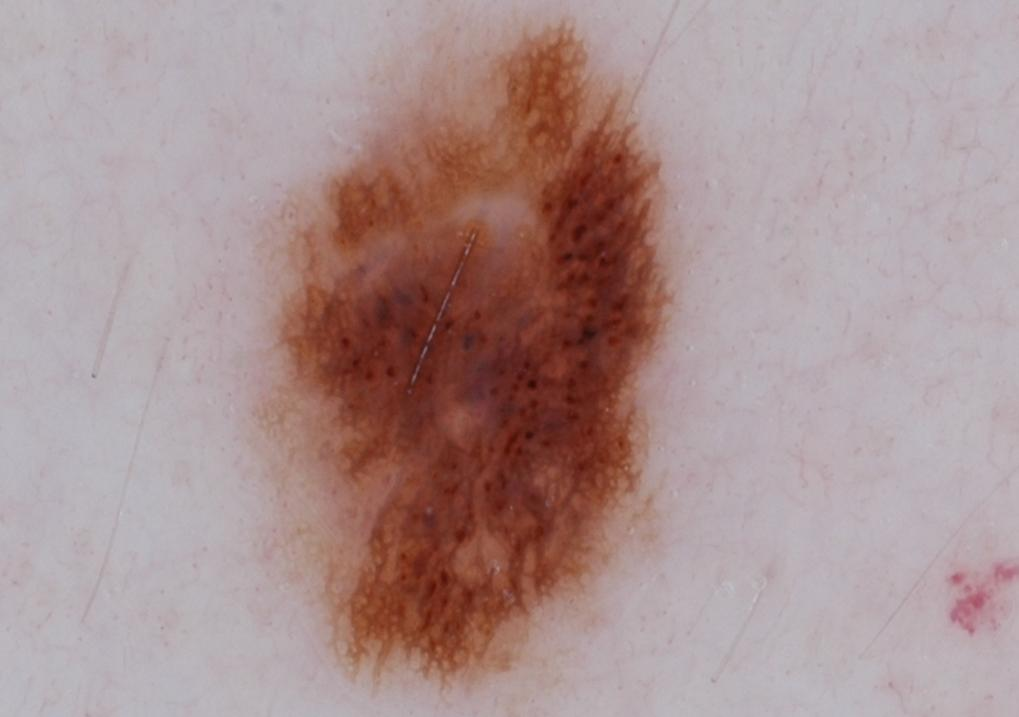

nevus_original_ISIC_0000374.jpg_1ad299cf-176e-4cb3-b014-e27b375892ca.jpg


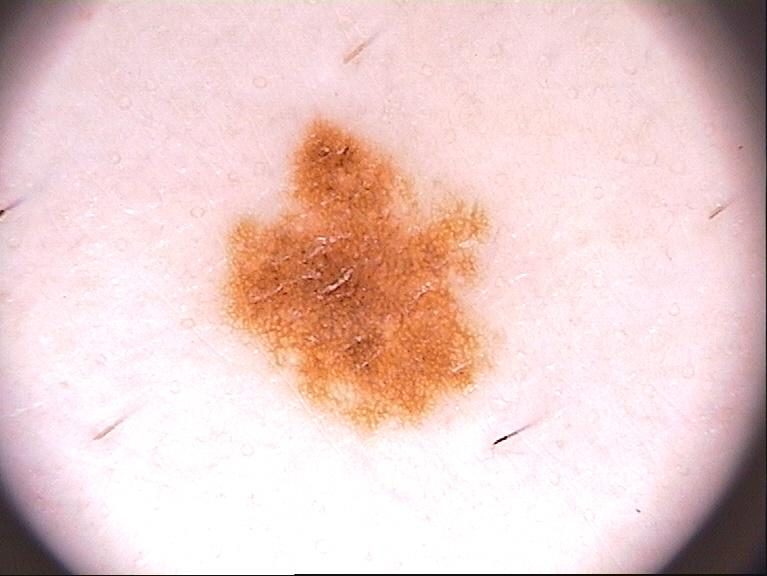

nevus_original_ISIC_0000065.jpg_21afd2cc-5079-4067-b77e-d6cb5142c968.jpg


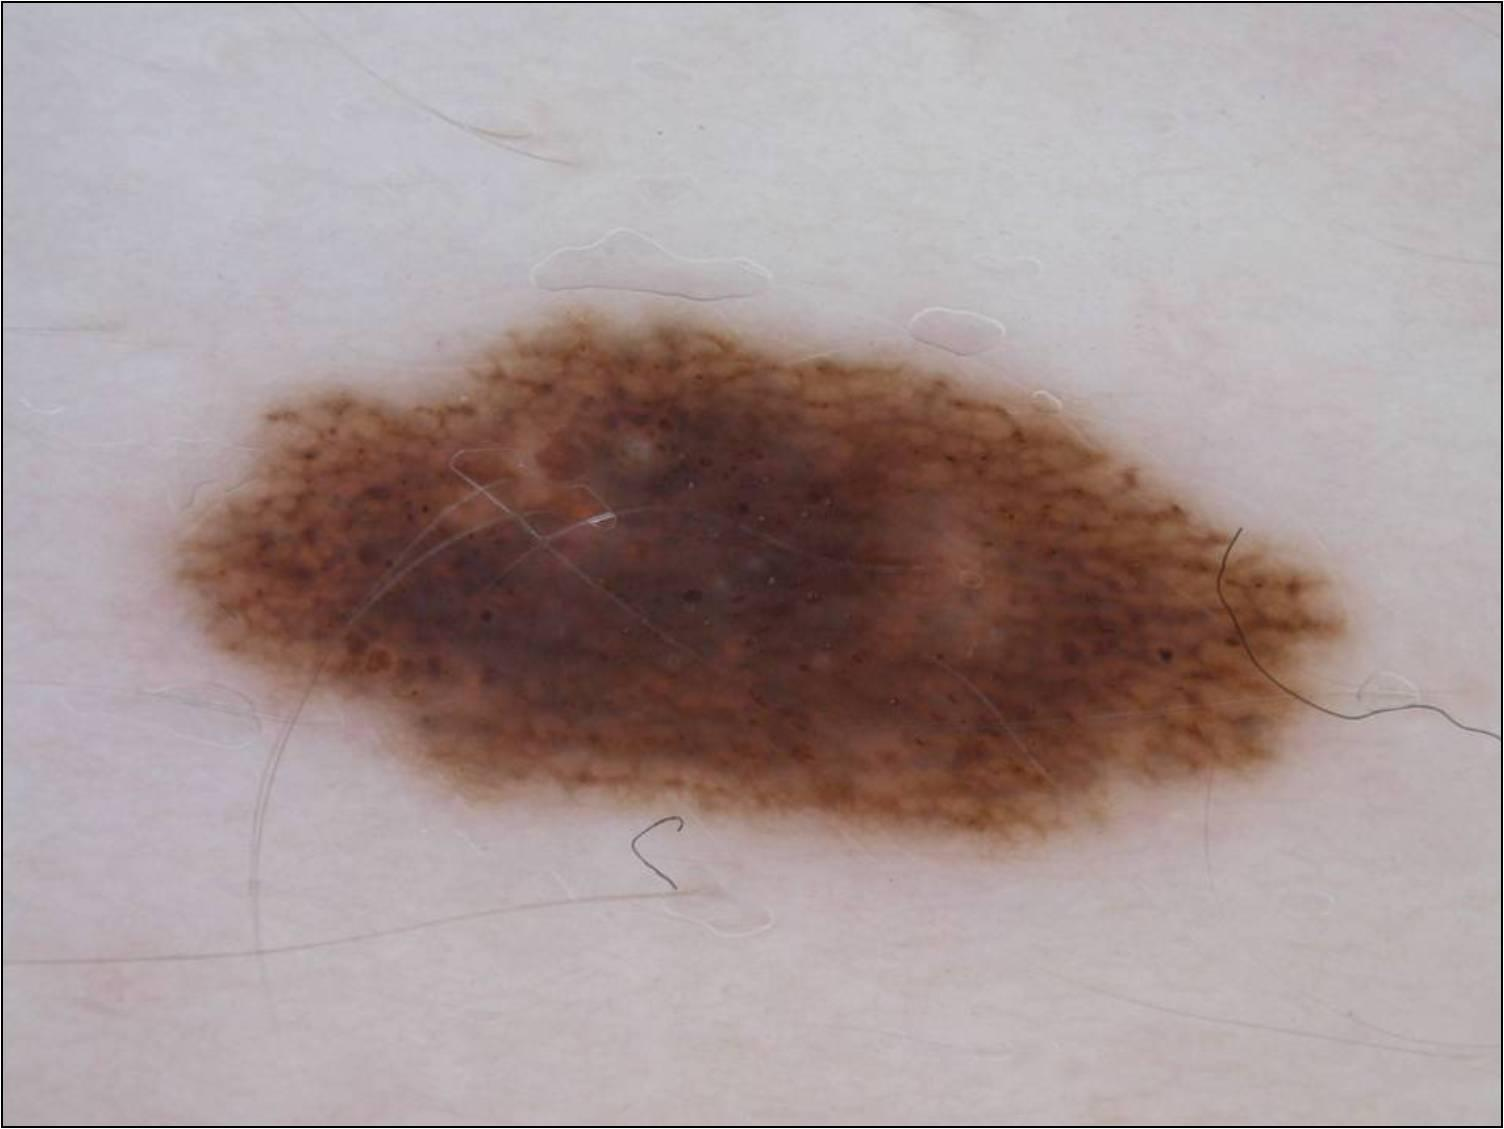

nevus_original_ISIC_0000351.jpg_a32a7054-316e-4984-bb38-e4bcc1753dca.jpg


In [90]:
from IPython.display import Image, display

for each in class_dict.keys():
    source_folder = f'/kaggle/input/augmented-melanoma-images/content/CNN_assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/{each}'
    aug_images = os.listdir(source_folder)
#   print(f"Augmented {each} images")

    i = 0
    for img in aug_images:
        print(img)
        if i < 5:
            display(Image(f"{source_folder}/{img}"))
            i += 1
        else:
            break

In [63]:
# Model Architecture
model_3 = Sequential()

model_3.add(layers.Rescaling(1./255,input_shape=(img_height,img_width,3)))   #Rescaling Layer

model_3.add(Conv2D(32, (3, 3), input_shape = (img_height, img_width, 32)))
model_3.add(Activation('relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))

model_3.add(Conv2D(64, (3, 3), input_shape = (img_height, img_width, 32)))
model_3.add(Activation('relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))

model_3.add(Conv2D(128, (3, 3), input_shape = (img_height, img_width, 32)))
model_3.add(Activation('relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))

model_3.add(layers.Dropout(0.5))

model_3.add(layers.Flatten())
model_3.add(layers.Dense(128,activation='relu'))
model_3.add(layers.Dropout(0.33))
model_3.add(layers.Dense(len(class_names),activation='softmax'))


model_3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

In [64]:
model_3.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 41, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
model_3_epochs = 30

# Train the model
history_3 = model_3.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=model_3_epochs
)

Epoch 1/30
  5/113 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1474 - auc: 0.5248 - loss: 2.9033

W0000 00:00:1721209716.742896     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.1926 - auc: 0.6170 - loss: 2.1952

W0000 00:00:1721209724.965007     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.1932 - auc: 0.6178 - loss: 2.1931 - val_accuracy: 0.3411 - val_auc: 0.8271 - val_loss: 1.6469
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3471 - auc: 0.8122 - loss: 1.6603 - val_accuracy: 0.4656 - val_auc: 0.8774 - val_loss: 1.3919
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4302 - auc: 0.8538 - loss: 1.4910 - val_accuracy: 0.5167 - val_auc: 0.9036 - val_loss: 1.2515
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5068 - auc: 0.8856 - loss: 1.3494 - val_accuracy: 0.5111 - val_auc: 0.8948 - val_loss: 1.2922
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5232 - auc: 0.9000 - loss: 1.2629 - val_accuracy: 0.6000 - val_auc: 0.9201 - val_loss: 1.1419
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5817 - auc: 0.9217 - loss: 1.1191 - val_accuracy: 0.5778 - val_auc: 0.9166 - val_loss: 1.1469
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 3

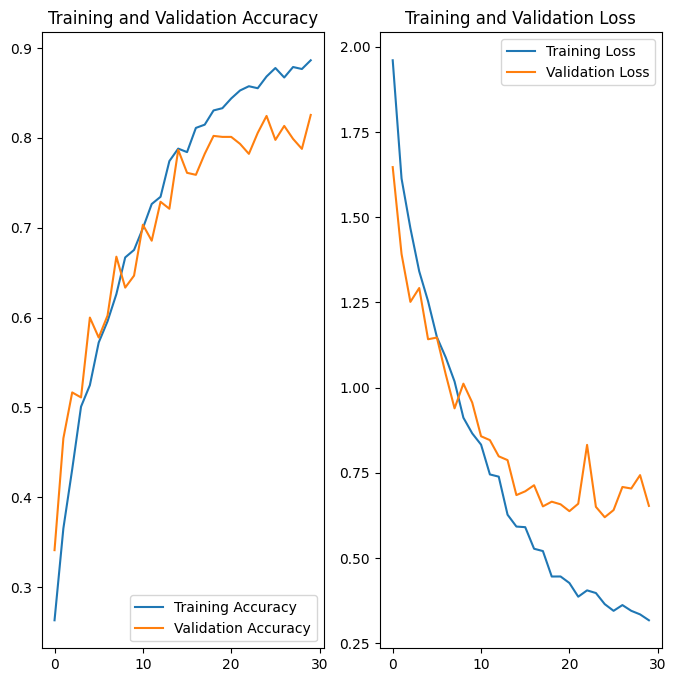

In [66]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs_range = range(model_3_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After augmenting images and using dropout layer, we have now fixed the overfitting issue and our model can predict Melanoma from images with an accruacy of ~80%. We can test it on the images that the model has not seen uptil now to truly validate the model.

In [86]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/augmented-melanoma-images/content/CNN_assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Test',
    image_size = (img_height, img_width),
    batch_size=1,
    labels='inferred',
    label_mode='categorical',
    seed = 123
)

# Evaluate the model on the test dataset
evaluation_metrics = model_3.evaluate(test_dataset)

Found 118 files belonging to 9 classes.
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4397 - auc: 0.7376 - loss: 5.6256
